# EDA OF TOP 5 INDIAN STOCKS LISTED ON NSE

In [26]:
# import necessary modules for adding backend to path
import sys
import os

#### ADDING BACKEND FOLDER TO PATH TO USE data_fetcher.py

In [27]:
# Add backend to path
backend_path = os.path.abspath('../backend')
if backend_path not in sys.path:
    sys.path.append(backend_path)

#### IMPORTING LIBRARIES

In [28]:
# Now import from backend
from data_fetcher import UpstoxDataFetcher

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 Starting Production EDA with Upstox Data")

🚀 Starting Production EDA with Upstox Data


#### INITIALIZE DATA FETCHER

In [29]:
# Initialize Upstox Data Fetcher
try:
    fetcher = UpstoxDataFetcher()
    print(f"✅ Upstox Data Fetcher initialized")
    print(f"📊 Available symbols: {len(fetcher.get_available_symbols())}")
    print(f"🕒 Market open: {fetcher.is_market_open()}")
except Exception as e:
    print(f"❌ Error initializing data fetcher: {e}")
    raise

INFO:data_fetcher:Initialized Upstox Data Fetcher with 50 instruments


✅ Upstox Data Fetcher initialized
📊 Available symbols: 50
🕒 Market open: False


#### FETCHING REAL MARKET DATA

In [30]:
# Fetch Real Market Data
symbols_to_analyze = ['RELIANCE', 'TCS', 'HDFCBANK', 'INFY', 'BHARTIARTL']
stock_data = {}

print("📈 Fetching historical data...")
for symbol in symbols_to_analyze:
    if symbol in fetcher.get_available_symbols():
        print(f"Fetching data for {symbol}...")
        data = fetcher.get_historical_data(symbol, days=365)  # 1 year
        if not data.empty:
            stock_data[symbol] = data
            print(f"✅ {symbol}: {len(data)} records")
        else:
            print(f"❌ {symbol}: No data received")
    else:
        print(f"❌ {symbol}: Not available in instruments")

print(f"📊 Loaded data for {len(stock_data)} stocks")

📈 Fetching historical data...
Fetching data for RELIANCE...
✅ RELIANCE: 248 records
Fetching data for TCS...
✅ TCS: 248 records
Fetching data for HDFCBANK...
✅ HDFCBANK: 248 records
Fetching data for INFY...
✅ INFY: 248 records
Fetching data for BHARTIARTL...
✅ BHARTIARTL: 248 records
📊 Loaded data for 5 stocks


#### CURRENT PRICE OF THE STOCK

In [31]:
#Current Prices
print("💰 Current/Latest Prices:")
current_prices = {}
for symbol in symbols_to_analyze:
    if symbol in stock_data:
        price_info = fetcher.get_current_price(symbol)
        if price_info:
            current_prices[symbol] = price_info
            price_type = "🔴 LIVE" if price_info['type'] == 'live' else "📅 LAST TRADING DAY"
            print(f"{symbol}: ₹{price_info['price']:.2f} ({price_type})")

💰 Current/Latest Prices:
RELIANCE: ₹1420.90 (📅 LAST TRADING DAY)
TCS: ₹3463.40 (📅 LAST TRADING DAY)
HDFCBANK: ₹1944.90 (📅 LAST TRADING DAY)
INFY: ₹1562.70 (📅 LAST TRADING DAY)
BHARTIARTL: ₹1856.20 (📅 LAST TRADING DAY)


#### TECHINCAL ANALYSIS FUNCTIONS

In [32]:
# Technical Analysis Functions
def calculate_technical_indicators(data):
    """Calculate technical indicators for the data"""
    data = data.copy()
    
    # Moving averages
    data['SMA_20'] = data['Close'].rolling(20).mean()
    data['SMA_50'] = data['Close'].rolling(50).mean()
    data['EMA_12'] = data['Close'].ewm(span=12).mean()
    data['EMA_26'] = data['Close'].ewm(span=26).mean()
    
    # MACD
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['MACD_Signal'] = data['MACD'].ewm(span=9).mean()
    
    # RSI
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands
    data['BB_Middle'] = data['Close'].rolling(20).mean()
    bb_std = data['Close'].rolling(20).std()
    data['BB_Upper'] = data['BB_Middle'] + (bb_std * 2)
    data['BB_Lower'] = data['BB_Middle'] - (bb_std * 2)
    
    # Volume indicators
    data['Volume_SMA'] = data['Volume'].rolling(20).mean()
    data['Volume_Ratio'] = data['Volume'] / data['Volume_SMA']
    
    # Returns and volatility
    data['Returns'] = data['Close'].pct_change()
    data['Volatility'] = data['Returns'].rolling(30).std() * np.sqrt(252)
    
    return data

# Apply technical indicators
for symbol in stock_data.keys():
    stock_data[symbol] = calculate_technical_indicators(stock_data[symbol])
    print(f"✅ Technical indicators calculated for {symbol}")


✅ Technical indicators calculated for RELIANCE
✅ Technical indicators calculated for TCS
✅ Technical indicators calculated for HDFCBANK
✅ Technical indicators calculated for INFY
✅ Technical indicators calculated for BHARTIARTL


#### COMPREHENSIVE DASHBOARD USING TECHNICAL FUNCTIONS

In [33]:
#Advanced Dashboard
def create_comprehensive_dashboard(data, symbol, current_price_info=None):
    """Create comprehensive dashboard for stock analysis"""
    fig = make_subplots(
        rows=6, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.02,
        subplot_titles=(
            f'{symbol} - Price & Moving Averages',
            'MACD',
            'RSI',
            'Bollinger Bands',
            'Volume Analysis',
            'Returns Distribution'
        ),
        row_heights=[0.25, 0.15, 0.15, 0.2, 0.15, 0.1]
    )
    
    # Price and Moving Averages with Current Price
    fig.add_trace(go.Candlestick(
        x=data['Date'],
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        name='Price'
    ), row=1, col=1)
    
    fig.add_trace(go.Scatter(x=data['Date'], y=data['SMA_20'], name='SMA 20', line=dict(color='orange')), row=1, col=1)
    fig.add_trace(go.Scatter(x=data['Date'], y=data['SMA_50'], name='SMA 50', line=dict(color='red')), row=1, col=1)
    
    # Add current price indicator if available
    if current_price_info:
        latest_date = data['Date'].iloc[-1]
        current_price = current_price_info['price']
        price_type = current_price_info['type']
        
        fig.add_trace(go.Scatter(
            x=[latest_date],
            y=[current_price],
            mode='markers',
            marker=dict(size=15, color='green' if price_type == 'live' else 'blue'),
            name=f'Current Price ({"Live" if price_type == "live" else "Last Trading"})',
            text=f"₹{current_price:.2f}"
        ), row=1, col=1)
    
    # MACD
    fig.add_trace(go.Scatter(x=data['Date'], y=data['MACD'], name='MACD', line=dict(color='blue')), row=2, col=1)
    fig.add_trace(go.Scatter(x=data['Date'], y=data['MACD_Signal'], name='Signal', line=dict(color='red')), row=2, col=1)
    
    # RSI
    fig.add_trace(go.Scatter(x=data['Date'], y=data['RSI'], name='RSI', line=dict(color='purple')), row=3, col=1)
    fig.add_hline(y=70, line_dash="dash", line_color="red", row=3, col=1)
    fig.add_hline(y=30, line_dash="dash", line_color="green", row=3, col=1)
    
    # Bollinger Bands
    fig.add_trace(go.Scatter(x=data['Date'], y=data['BB_Upper'], name='BB Upper', line=dict(color='gray')), row=4, col=1)
    fig.add_trace(go.Scatter(x=data['Date'], y=data['BB_Middle'], name='BB Middle', line=dict(color='blue')), row=4, col=1)
    fig.add_trace(go.Scatter(x=data['Date'], y=data['BB_Lower'], name='BB Lower', line=dict(color='gray')), row=4, col=1)
    fig.add_trace(go.Scatter(x=data['Date'], y=data['Close'], name='Close', line=dict(color='black')), row=4, col=1)
    
    # Volume
    fig.add_trace(go.Bar(x=data['Date'], y=data['Volume'], name='Volume', marker_color='lightblue'), row=5, col=1)
    fig.add_trace(go.Scatter(x=data['Date'], y=data['Volume_SMA'], name='Volume SMA', line=dict(color='red')), row=5, col=1)
    
    # Returns histogram
    fig.add_trace(go.Histogram(x=data['Returns'].dropna(), name='Returns Distribution', nbinsx=50), row=6, col=1)
    
    fig.update_layout(height=1200, title_text=f"{symbol} - Comprehensive Analysis")
    return fig

# Display comprehensive dashboards
for symbol, data in stock_data.items():
    current_info = current_prices.get(symbol)
    fig = create_comprehensive_dashboard(data, symbol, current_info)
    fig.show()

#### CORRELATION ANALYSIS OF TOP 5 STOCKS

=== CORRELATION ANALYSIS ===


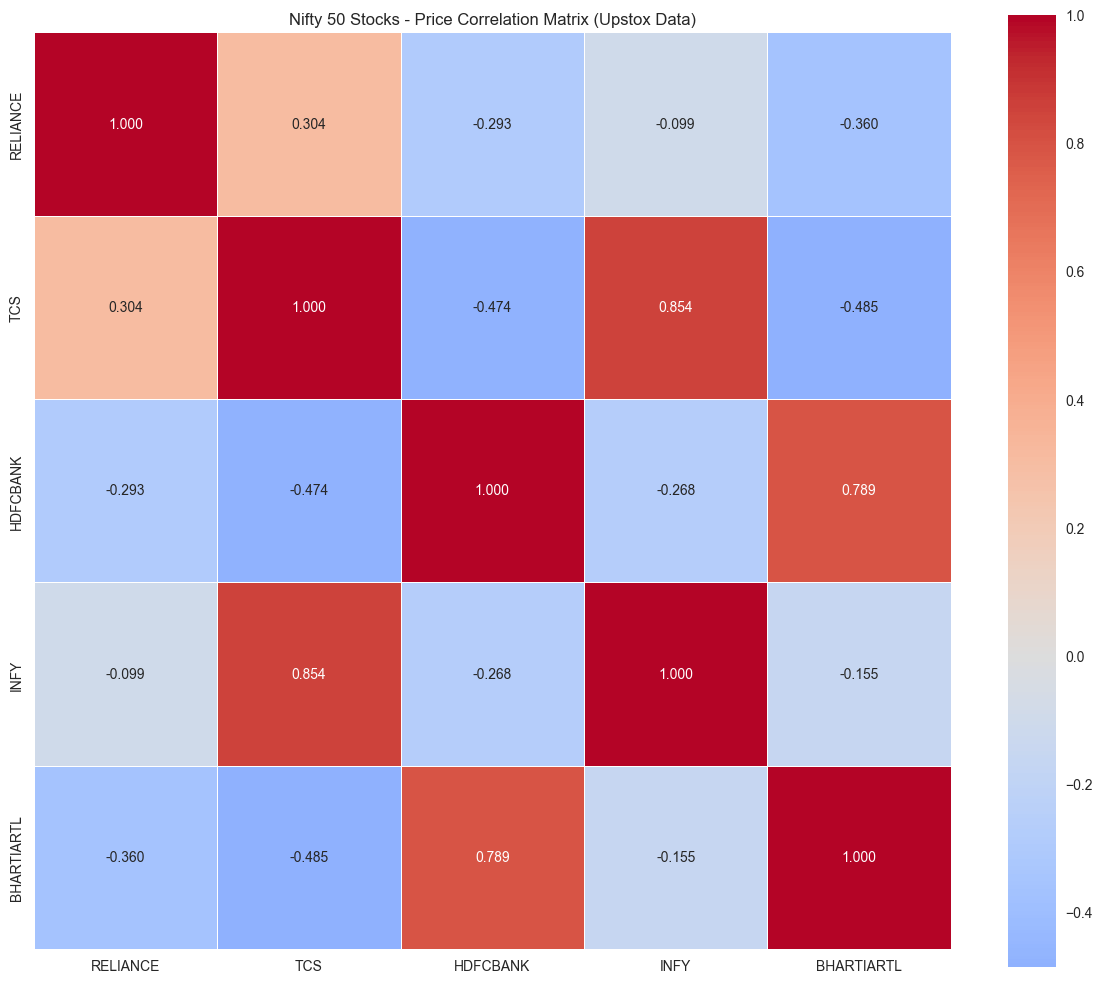

In [34]:
# Correlation Analysis
print("=== CORRELATION ANALYSIS ===")

if len(stock_data) > 1:
    close_prices = pd.DataFrame()
    for symbol, data in stock_data.items():
        close_prices[symbol] = data.set_index('Date')['Close']

    correlation_matrix = close_prices.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5, fmt='.3f')
    plt.title('Nifty 50 Stocks - Price Correlation Matrix (Upstox Data)')
    plt.tight_layout()
    plt.show()

#### PERFORMANCE SUMMARY

In [35]:
# Performance Summary
print("=== PERFORMANCE SUMMARY ===")
performance_summary = []

for symbol, data in stock_data.items():
    if len(data) > 0:
        current_info = current_prices.get(symbol, {})
        current_price = current_info.get('price', data['Close'].iloc[-1])
        start_price = data['Close'].iloc[0]
        total_return = ((current_price / start_price) - 1) * 100
        
        volatility = data['Returns'].std() * np.sqrt(252) * 100
        avg_volume = data['Volume'].mean()
        max_price = data['High'].max()
        min_price = data['Low'].min()
        
        performance_summary.append({
            'Symbol': symbol,
            'Current Price': f"₹{current_price:.2f}",
            'Total Return %': f"{total_return:.2f}%",
            'Volatility %': f"{volatility:.2f}%",
            'Avg Volume': f"{avg_volume:,.0f}",
            'Max Price': f"₹{max_price:.2f}",
            'Min Price': f"₹{min_price:.2f}",
            'Data Points': len(data)
        })

performance_df = pd.DataFrame(performance_summary)
print(performance_df.to_string(index=False))

# Cell 9: Save Data
import os
os.makedirs('../data', exist_ok=True)

for symbol, data in stock_data.items():
    filename = f"../data/{symbol}_upstox_data.csv"
    data.to_csv(filename, index=False)
    print(f"✅ Saved {symbol} data to {filename}")

# Save performance summary
performance_df.to_csv('../data/performance_summary.csv', index=False)

# Save current prices
if current_prices:
    current_prices_df = pd.DataFrame(current_prices).T
    current_prices_df.to_csv('../data/current_prices.csv')

print("🎉 EDA completed successfully with real data!")
print(f"📊 Analyzed {len(stock_data)} stocks")
print(f"📈 Data saved to ../data/ directory")

=== PERFORMANCE SUMMARY ===
    Symbol Current Price Total Return % Volatility % Avg Volume Max Price Min Price  Data Points
  RELIANCE      ₹1420.90         -0.66%       23.81% 13,751,711  ₹1608.80  ₹1114.85          248
       TCS      ₹3463.40         -5.65%       22.13%  2,495,808  ₹4592.25  ₹3056.05          248
  HDFCBANK      ₹1944.90         26.99%       20.94% 16,691,551  ₹1978.90  ₹1454.00          248
      INFY      ₹1562.70         11.07%       26.17%  7,132,269  ₹2006.45  ₹1307.00          248
BHARTIARTL      ₹1856.20         35.22%       23.91%  6,976,506  ₹1917.00  ₹1219.05          248
✅ Saved RELIANCE data to ../data/RELIANCE_upstox_data.csv
✅ Saved TCS data to ../data/TCS_upstox_data.csv
✅ Saved HDFCBANK data to ../data/HDFCBANK_upstox_data.csv
✅ Saved INFY data to ../data/INFY_upstox_data.csv
✅ Saved BHARTIARTL data to ../data/BHARTIARTL_upstox_data.csv
🎉 EDA completed successfully with real data!
📊 Analyzed 5 stocks
📈 Data saved to ../data/ directory
